# LSP Ti-6Al-4V Depth Stress Scan

This notebook presents an example analysis of residual stresses at P61A.

###### Sample:
100 × 20 × 1 mm thick Ti-6Al-4V sheet with Laser Shock Peening treated surface.

###### Experiment parameters:
Measurements in transmission.
Incident beam 50 × 50 μm, detector 2Θ = 5.274° calibrated using NIST 640f powder.

###### Experimental procedure:
1. Orient the sample with surface parallel to the beam at half of the beam height.
2. Rotate the sample by Θ around x, so that the incident and diffracted beam fall at the same angle to its surface.
3. Perform *eu.chi* scan for every *eu.z* position for two *eu.phi* orientations 0° and 90°. *eu.z* puts the gauge volume at a certain depth in the sample, and for each depth a $\sin^2(\psi)$ scan is performed for $\varphi \in \{0^{\circ}, 90^{\circ}\}$. For the purposes of $\sin^2(\psi)$ method, *eu.phi* is $\varphi$ and *eu.chi* is $\psi$.
4. Diffraction patterns were analysed using P61A::Viewer. Peaks exported from the Viewer are the starting point of this analysis.

## Imports

In [10]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from uncertainties import unumpy, ufloat

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# This has to be the path to P61AToolkit/src/py61a.
# If you are launching the notebook from P61AToolkit/src/notebooks it is correct,
# otherwise change it accordingly.
sys.path.append('../py61a')
from py61a.viewer_utils import read_peaks, get_peak_ids, peak_id_str, group_by_motors
from py61a.cryst_utils import bragg, tau, mu
from py61a.stress import sin2psi, deviatoric_stresses, all_stresses

%matplotlib inline

## Definitions / constants

In [11]:
# 2Theta angle
tth_ch1 = 5.274
# Main element in the alloy, will be used for absorption calculation
element = 'Ti'
# Diffraction elactic constants prepared using ISODEC https://www.nist.gov/services-resources/software/isodec
dec = pd.read_csv(r'../../data/dec/alphaTi.csv', index_col=None, comment='#')
# Eulerian cradle misalignment correction
corr_zs = [-52.2499991678931, -52.23848411891115, -52.22980850484977, -52.210716154902826, -52.18639547360999, -52.17410908764032, -52.15233981853313, -52.129560042786835, -52.10937437512792, -52.089129901000966, -52.07366400235897, -52.05810463395996, -52.04510964639764, -52.03484623353578, -52.02628011824553, -52.020720504940556, -52.016254989424496, -52.01363002815571, -52.01695812204535, -52.02214360061359, -52.028103526384406]
corr_chis = [0.0, 4.5, 9.0, 13.5, 18.0, 22.5, 27.0, 31.5, 36.0, 40.5, 45.0, 49.5, 54.0, 58.5, 63.0, 67.5, 72.0, 76.5, 81.0, 85.5, 90.0]

## $d_0$ measurement preparation
A reference sample was measured to get the $d_0$ values for the diffraction peaks.

In [12]:
# read Viewer output
d0_data = read_peaks(r'../../data/peaks/TiLSP/Ti_1mm_d0_ref.csv')
# create a dataframe for storing d0 values
d0 = pd.DataFrame(columns=['h', 'k', 'l', 'd0', 'd0_std', 'en'])
for peak_id in get_peak_ids(d0_data, columns=('h', 'k', 'l', 'phase')):
    # calculating the d value from the peak center and 2Theta
    d_val = bragg(en=ufloat(d0_data[peak_id]['center'].mean(), d0_data[peak_id]['center'].std()), tth=tth_ch1)['d']
    # adding to the d0 dataframe as a new row
    d0.loc[d0.shape[0]] = {
        **{idx: d0_data[peak_id][idx].mean().astype(int) for idx in ('h', 'k', 'l')},
        'd0': d_val.nominal_value,
        'd0_std': d_val.std_dev,
        'en': d0_data[peak_id]['center'].mean()
    }
# showing results: hkl, measured d0, measured d0 standard deviation, energy of the peak
d0 = d0.sort_values(by='en').reset_index(drop=True)
d0

,h,k,l,d0,d0_std,en
0,1,0,0,2.532843,0.000550,53.197829
1,0,0,2,2.335838,0.000622,57.684555
2,1,0,1,2.227108,0.000479,60.500767
3,1,0,2,1.717717,0.000366,78.442366
4,1,1,0,1.463043,0.000455,92.096946
5,1,0,3,1.327186,0.000373,101.524369
6,2,0,0,1.267117,0.000715,106.337267
7,1,1,2,1.240123,0.000234,108.651924
8,2,0,1,1.222798,0.000458,110.191368
9,0,0,4,1.168465,0.000659,115.315181


## Deviatoric stress components
To calculate $(\sigma_{11} - \sigma_{33})$ and $(\sigma_{22} - \sigma_{33})$ one does not need to know $d_0$ precisely. This makes the results very robust.

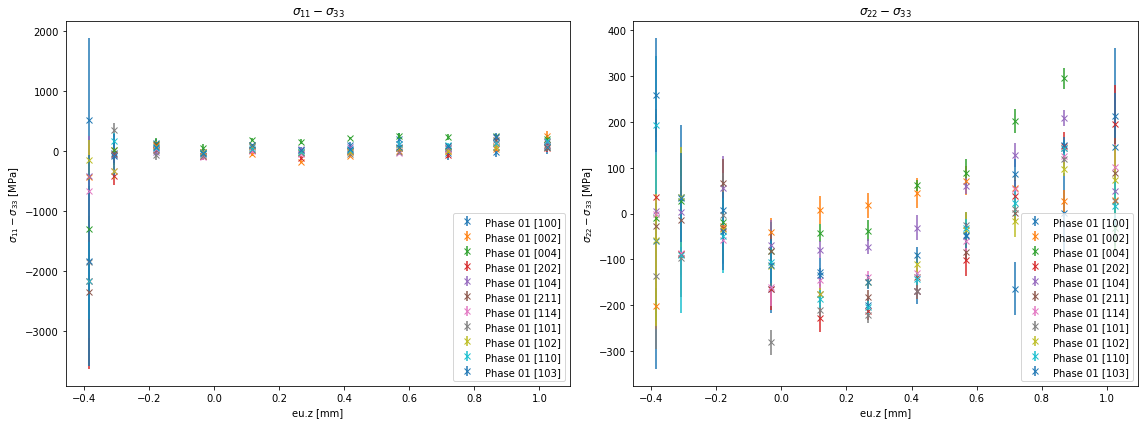

In [13]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = deviatoric_stresses(dd, analysis, dec)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 6))
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.set_title(r'$\sigma_{11}-\sigma_{33}$')
ax2.set_title(r'$\sigma_{22}-\sigma_{33}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}-\sigma_{33}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}-\sigma_{33}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11-s33' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

## All measured stress components
Using the prepared $d_0$ values

These plots show all tensor components only as an example. Non-diagonal $\sigma$ elements are incorrect, because for  $\sigma_{12}$ no measurements at $\varphi \in \{45^{\circ}, 135^{\circ}, 225^{\circ}, 315^{\circ}\}$ and for $\sigma_{13}$, $\sigma_{23}$ no measurements at $\varphi \in \{180^{\circ}, 270^{\circ}\}$ were performed.

Note that the $\sigma$ values for $[002]$ are really off. Given that the deviatoric components (shown later) match, this probably means that the $d_0$ measurement for this peak was inaccurate.

No handles with labels found to put in legend.


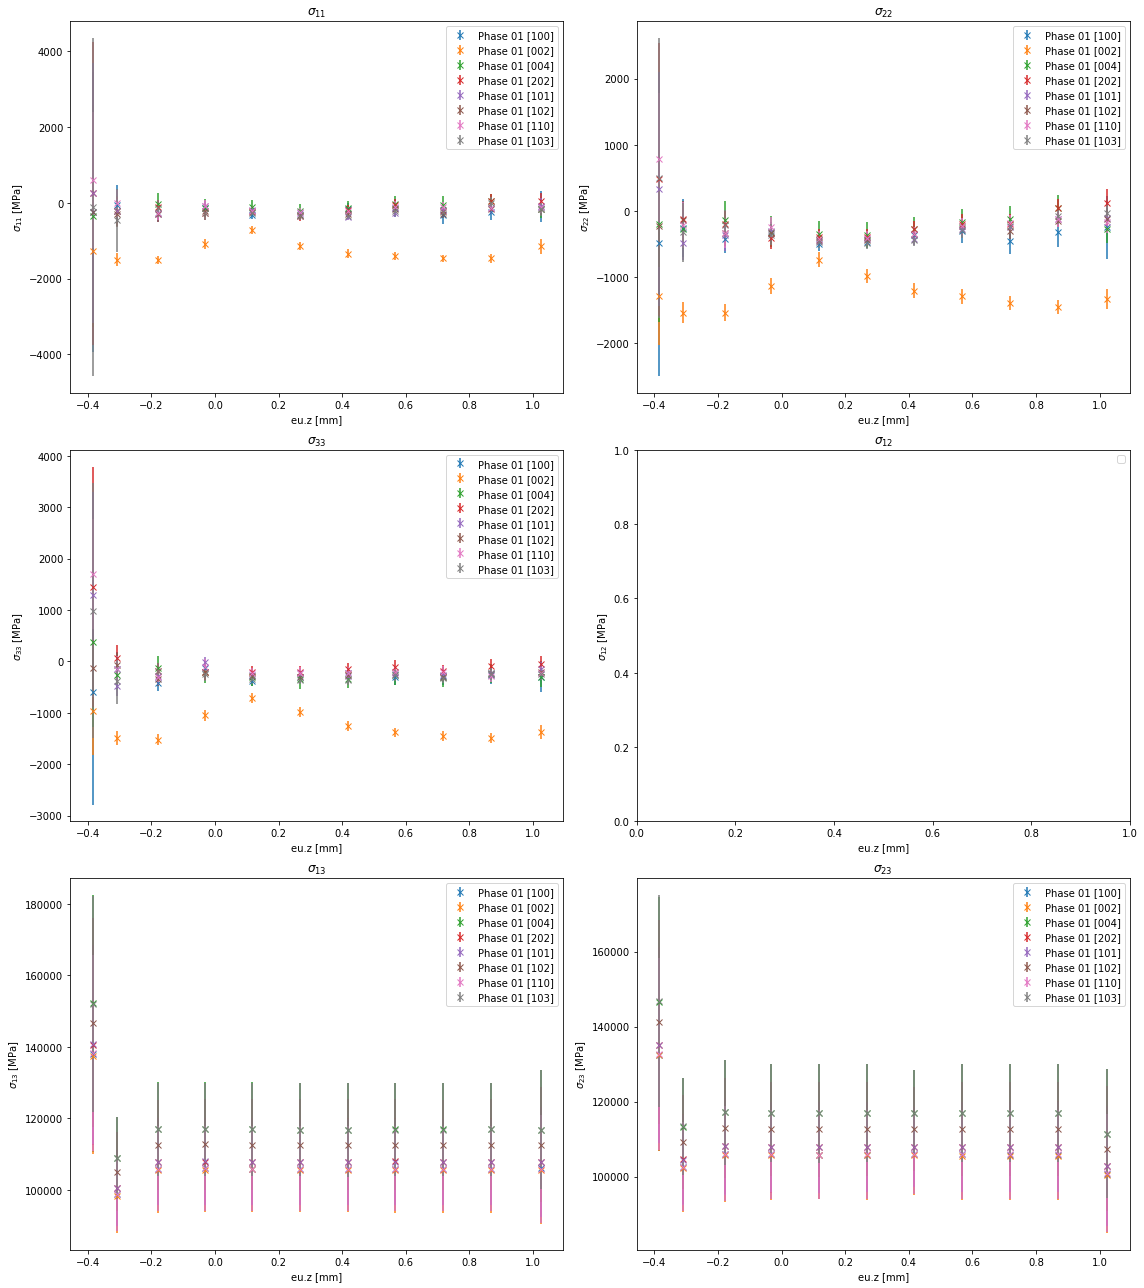

In [14]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = all_stresses(dd, analysis, dec, d0)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1, ax2 = plt.subplot(321), plt.subplot(322)
ax3, ax4 = plt.subplot(323), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11}$')
ax2.set_title(r'$\sigma_{22}$')
ax3.set_title(r'$\sigma_{33}$')
ax4.set_title(r'$\sigma_{12}$')
ax5.set_title(r'$\sigma_{13}$')
ax6.set_title(r'$\sigma_{23}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}$ [MPa]')
ax3.set_ylabel('$\sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{12}$ [MPa]')
ax5.set_ylabel('$\sigma_{13}$ [MPa]')
ax6.set_ylabel('$\sigma_{23}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's33' in stress[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's12' in stress[peak_id].columns:
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's12')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's12')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's13' in stress[peak_id].columns:
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's13')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's13')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's23' in stress[peak_id].columns:
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's23')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's23')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.tight_layout()
plt.show()

## Deviatoric component comparison: 
The purpose of this example is to compare deviatoric $(\sigma_{11} - \sigma_{33})$ and $(\sigma_{22} - \sigma_{33})$ stress tensor components calculated using $d_0$ and calculated without $d_0$. If the $d_0$ measurements were correct and applicable (there is no, for example, chemically induced $d_0$ variation over depth), the deviatoric components should match.

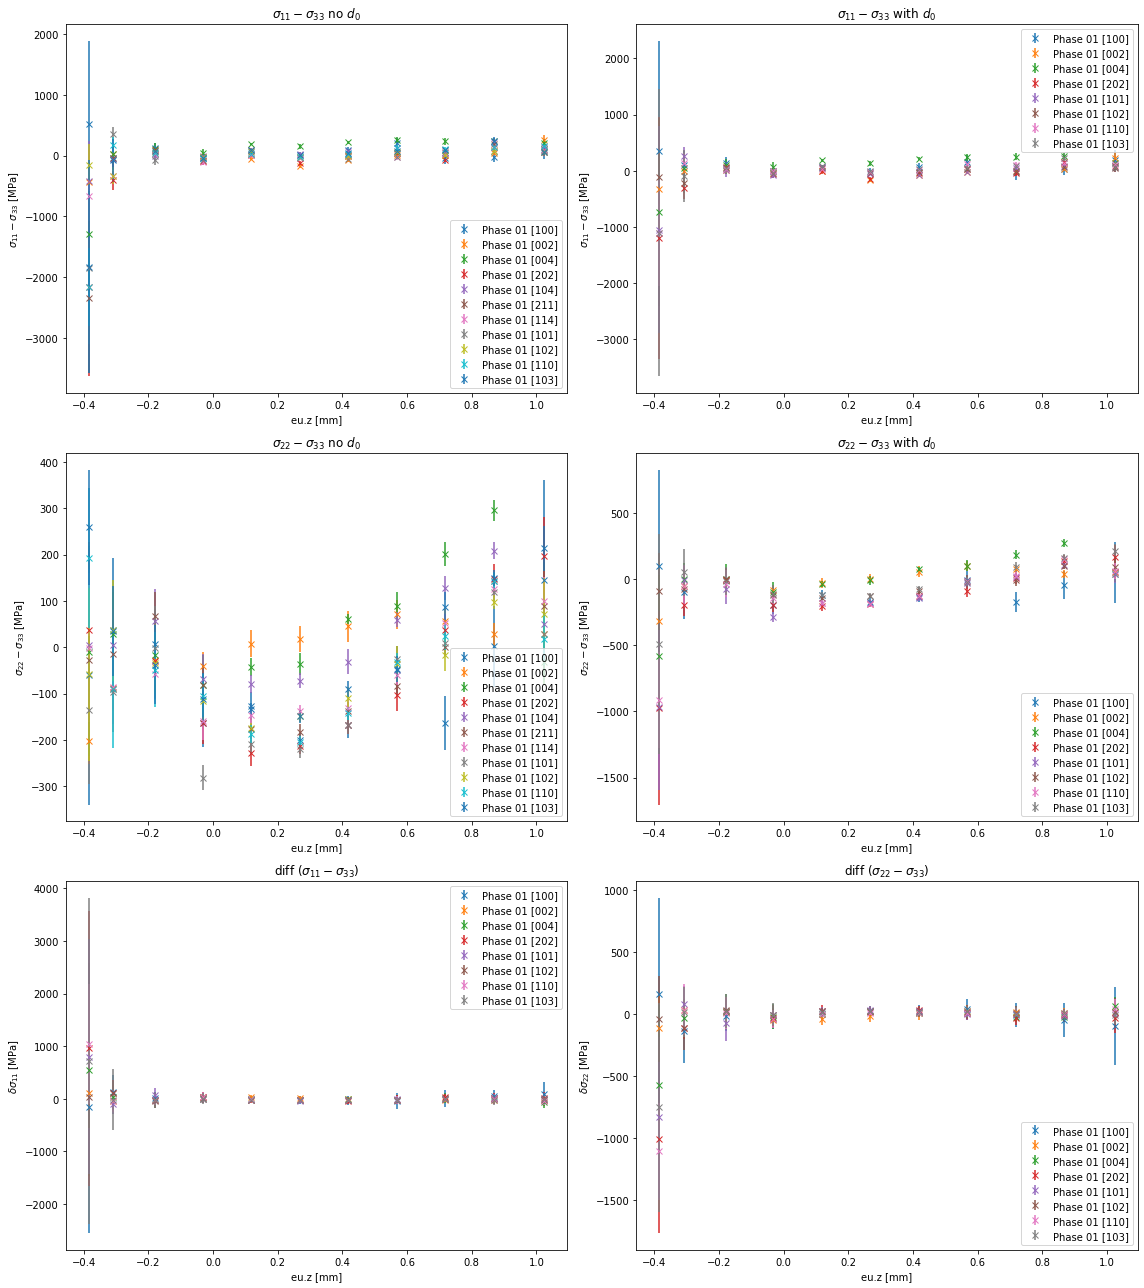

In [15]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress_dev = deviatoric_stresses(dd, analysis, dec)
stress_dev = stress_dev.reset_index()
stress_dev.set_index('eu.z', inplace=True)

stress = all_stresses(dd, analysis, dec, d0)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)

z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1, ax2 = plt.subplot(321), plt.subplot(322)
ax3, ax4 = plt.subplot(323), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11} - \sigma_{33}$ no $d_0$')
ax2.set_title(r'$\sigma_{11} - \sigma_{33}$ with $d_0$')
ax3.set_title(r'$\sigma_{22} - \sigma_{33}$ no $d_0$')
ax4.set_title(r'$\sigma_{22} - \sigma_{33}$ with $d_0$')
ax5.set_title(r'diff $(\sigma_{11} - \sigma_{33})$')
ax6.set_title(r'diff $(\sigma_{22} - \sigma_{33})$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11} - \sigma_{33}$ [MPa]')
ax2.set_ylabel('$\sigma_{11} - \sigma_{33}$ [MPa]')
ax3.set_ylabel('$\sigma_{22} - \sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{22} - \sigma_{33}$ [MPa]')
ax5.set_ylabel('$\delta \sigma_{11}$ [MPa]')
ax6.set_ylabel('$\delta \sigma_{22}$ [MPa]')

for peak_id in sorted(set(stress_dev.columns.get_level_values(0))):

    if 's11-s33' in stress_dev[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress_dev.index].values.flatten(),
            y=unumpy.nominal_values(stress_dev.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress_dev.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress_dev[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress_dev.index].values.flatten(),
            y=unumpy.nominal_values(stress_dev.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress_dev.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if ('s11' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's11')] - stress.loc[:, (peak_id, 's33')]
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if ('s22' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's22')] - stress.loc[:, (peak_id, 's33')]
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

        
for peak_id in sorted(set(stress.columns.get_level_values(0)) & set(stress_dev.columns.get_level_values(0))):
    
    if ('s11-s33' in stress_dev[peak_id].columns) and ('s11' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's11')] - stress.loc[:, (peak_id, 's33')] - stress_dev.loc[:, (peak_id, 's11-s33')]
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
    
    if ('s22-s33' in stress_dev[peak_id].columns) and ('s22' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's22')] - stress.loc[:, (peak_id, 's33')] - stress_dev.loc[:, (peak_id, 's22-s33')]
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()

plt.tight_layout()
plt.show()

## Selecting data by intensity

In a perfect measurement all peaks would be showing the same stress state. In reality there are various sources for errors: microstructural variations and potential gauge volume undersampling, low signal/noise ratio for some peaks, incorrect backgriund estimation, etc.

One way of eliminating errors can be removing from analysis the peaks that have not reached a certain prominence treshold.

The $[002]$ peak with incorrect $d_0$ is also removed from the analysis.

No handles with labels found to put in legend.


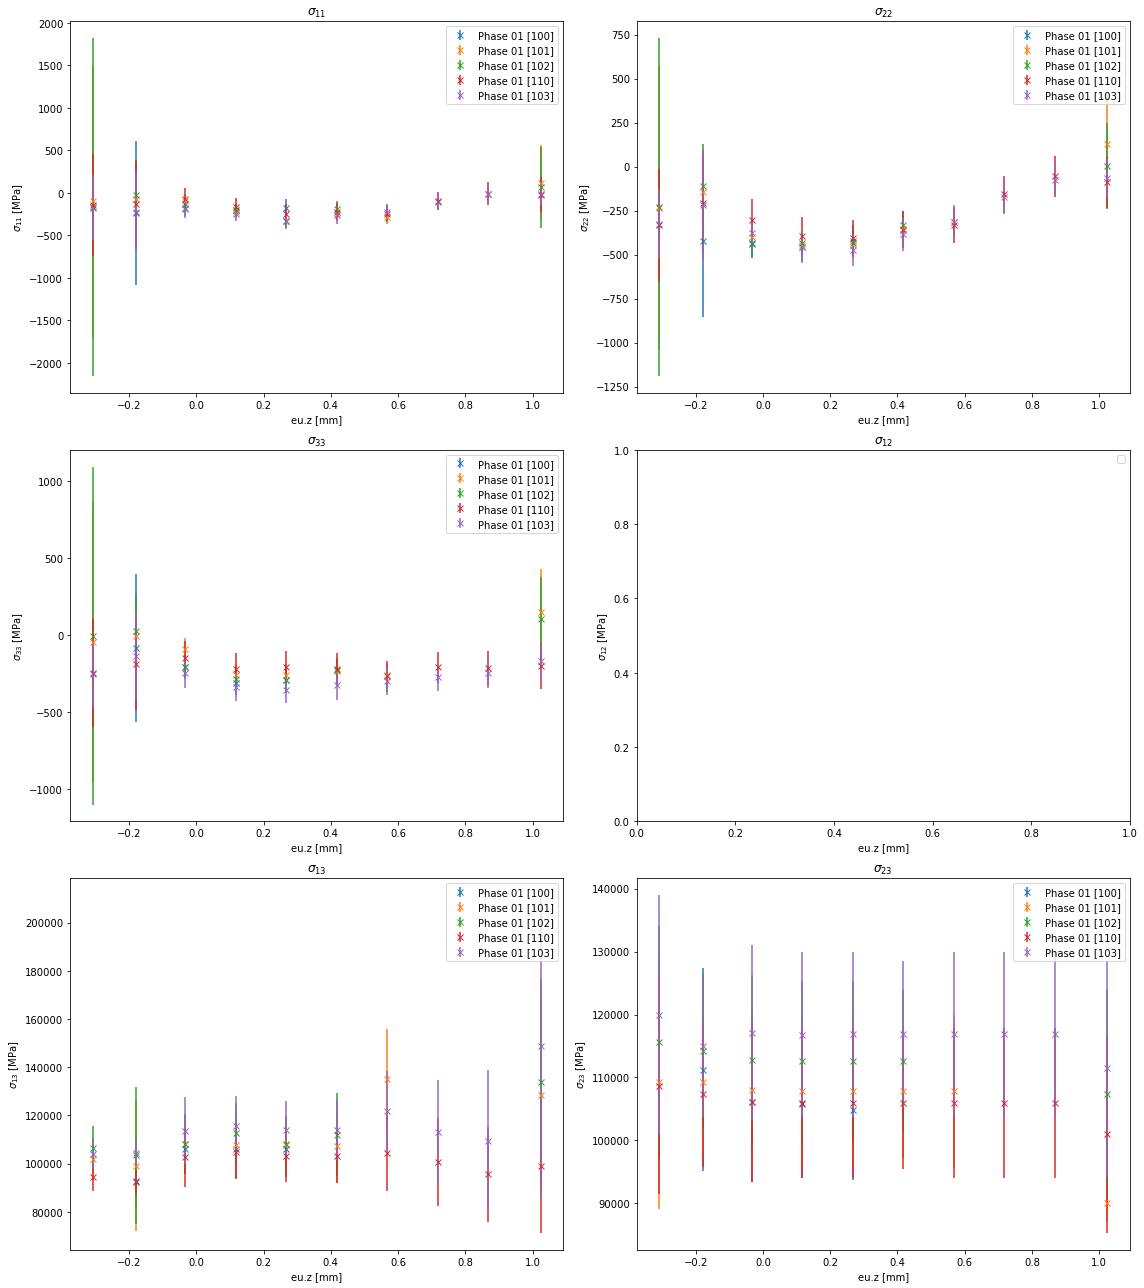

In [16]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

min_height = 1e2
d0_ = d0.drop(index=[1])


for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    if dd[(peak_id, 'height')].max() < min_height:
        dd.drop(columns=peak_id, inplace=True, level=0)
        continue
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)
    dd.loc[dd[(peak_id, 'height')] < min_height, (peak_id, 'd')] = np.nan

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = all_stresses(dd, analysis, dec, d0_)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1, ax2 = plt.subplot(321), plt.subplot(322)
ax3, ax4 = plt.subplot(323), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11}$')
ax2.set_title(r'$\sigma_{22}$')
ax3.set_title(r'$\sigma_{33}$')
ax4.set_title(r'$\sigma_{12}$')
ax5.set_title(r'$\sigma_{13}$')
ax6.set_title(r'$\sigma_{23}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}$ [MPa]')
ax3.set_ylabel('$\sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{12}$ [MPa]')
ax5.set_ylabel('$\sigma_{13}$ [MPa]')
ax6.set_ylabel('$\sigma_{23}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's33' in stress[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's12' in stress[peak_id].columns:
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's12')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's12')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's13' in stress[peak_id].columns:
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's13')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's13')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's23' in stress[peak_id].columns:
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's23')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's23')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.tight_layout()
plt.show()

## Averaging over peaks -- deviatoric

This sample is known to have texture, so the $\sin^2 ( \psi )$ curves are strongly oscillating.
According to Hauk, a solution for this could be averaging over peaks

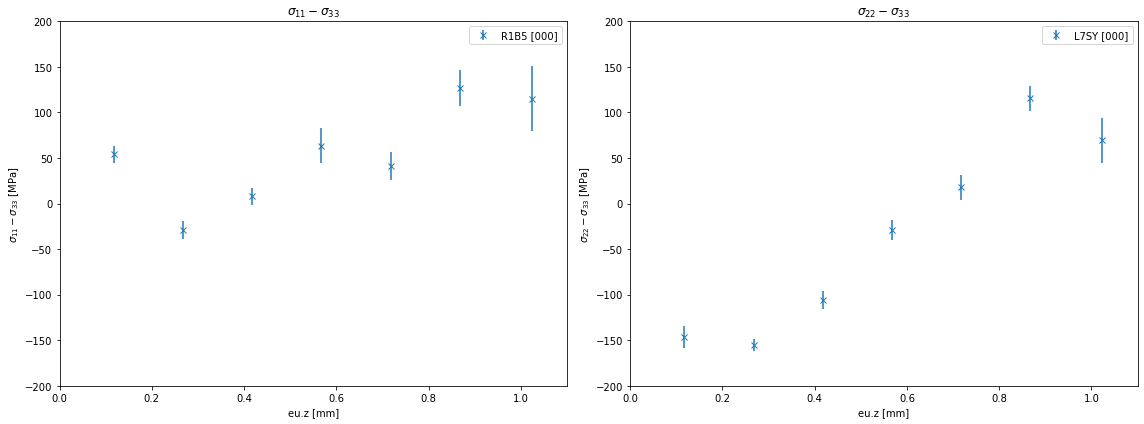

In [20]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

# dropping peaks that do not belong to the alpha Ti phase
all_peaks = set(dd.columns.get_level_values(0))
all_peaks.remove('md')
for peak_id in all_peaks:
    if peak_id not in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
        dd.drop(columns=peak_id, inplace=True, level=0)

# calculating d values from peak positions
for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# averaging all peaks
peak_data = dd.copy(deep=True)
peak_data.drop(columns=['md'], inplace=True, level=0)
peak_data.drop(columns=['phase'], inplace=True, level=1)
peak_data = peak_data.groupby(level=[1], axis=1).agg(np.mean)
peak_data['h'] = 0
peak_data['k'] = 0
peak_data['l'] = 0
peak_data.columns = pd.MultiIndex.from_product([['all_0'], peak_data.columns])
meta_data = dd['md'].copy(deep=True)
meta_data.columns = pd.MultiIndex.from_product([['md'], meta_data.columns])
dd = pd.concat([meta_data, peak_data], axis=1)

# preparing fake DEC from bulk elastic constants
dec_ = pd.DataFrame({'h': [0], 'k': [0], 'l': [0], 's1': [-0.342 / 113.8e3], 'hs2': [(1 + 0.342) / 113.8e3]})

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = deviatoric_stresses(dd, analysis, dec_)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharey=ax1)
ax1.set_title(r'$\sigma_{11}-\sigma_{33}$')
ax2.set_title(r'$\sigma_{22}-\sigma_{33}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}-\sigma_{33}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}-\sigma_{33}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11-s33' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
ax1.set_ylim((-200, 200))
ax2.set_ylim((-200, 200))
ax1.set_xlim((0, 1.1))
ax2.set_xlim((0, 1.1))
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

## Averaging over peaks -- all

Averaging over HKL: [(1, 1, 0), (1, 0, 3), (1, 0, 0), (2, 0, 2), (1, 0, 1), (1, 1, 2), (2, 0, 1), (0, 0, 4), (1, 0, 2), (2, 0, 0)]


No handles with labels found to put in legend.


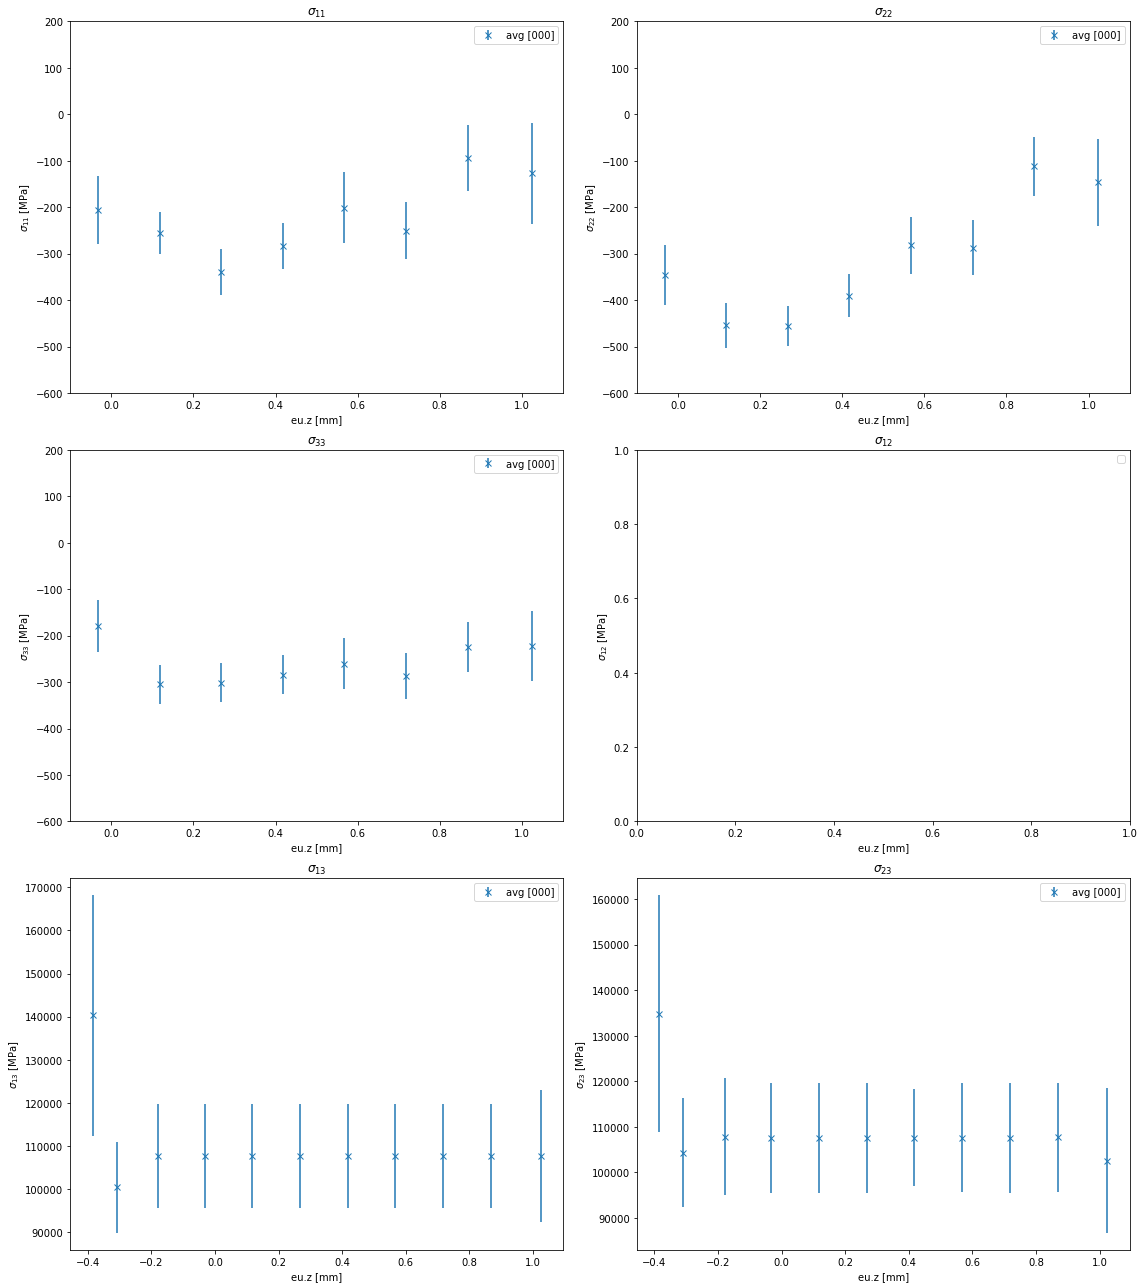

In [24]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

dd.loc[:, ('md', 'eu.z')] = dd.loc[:, ('md', 'eu.z')] - np.interp(dd.loc[:, ('md', 'eu.chi')].to_numpy(), corr_chis, corr_zs)

# dropping the peak with bad d0
d0_ = d0.drop(index=[1])

# dropping peaks that do not belong to the alpha Ti phase
all_peaks = set(dd.columns.get_level_values(0))
all_peaks.remove('md')
for peak_id in all_peaks:
    if peak_id not in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
        dd.drop(columns=peak_id, inplace=True, level=0)
        continue
    
    if any(np.isnan(dd[peak_id]['center'])):
        dd.drop(columns=peak_id, inplace=True, level=0)
        continue
    
# setting up HKL present for both d0 and collected peaks
hkl_collected = [
    tuple(dd[peak_id][['h', 'k', 'l']].mean().astype(np.int).to_list()) 
    for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std'))
]

hkl_d0 = [
    tuple(row[['h', 'k', 'l']].astype(np.int)) for ii, row in d0_.iterrows()
]

hkl_present = list(set(hkl_d0) & set(hkl_collected))
print('Averaging over HKL:', hkl_present)

# dropping peaks from both d0_ and peaks 
for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    if tuple(dd[peak_id][['h', 'k', 'l']].mean().astype(np.int).to_list()) not in hkl_present:
        dd.drop(columns=peak_id, inplace=True, level=0)

ids_to_drop = []
for ii, row in d0_.iterrows():
    if tuple(row[['h', 'k', 'l']].astype(np.int)) not in hkl_present:
        ids_to_drop.append(ii)
d0_.drop(ids_to_drop, inplace=True)

#calculating d values from peak positions
for peak_id in get_peak_ids(dd, columns=('h', 'k', 'l', 'center', 'center_std')):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# averaging all peaks
peak_data = dd.copy(deep=True)
peak_data.drop(columns=['md'], inplace=True, level=0)
peak_data.drop(columns=['phase'], inplace=True, level=1)
peak_data = peak_data.groupby(level=[1], axis=1)
peak_data = peak_data.agg(np.mean)
peak_data['h'] = 0
peak_data['k'] = 0
peak_data['l'] = 0
peak_data['phase'] = 'avg'
peak_data.columns = pd.MultiIndex.from_product([['all_0'], peak_data.columns])
meta_data = dd['md'].copy(deep=True)
meta_data.columns = pd.MultiIndex.from_product([['md'], meta_data.columns])
dd = pd.concat([meta_data, peak_data], axis=1)

# preparing fake DEC from bulk elastic constants
dec_ = pd.DataFrame({'h': [0], 'k': [0], 'l': [0], 's1': [-0.342 / 113.8e3], 'hs2': [(1 + 0.342) / 113.8e3]})
# preparing fake d0 as average d0
d0_ = unumpy.uarray(d0_['d0'].to_numpy(), d0_['d0_std'].to_numpy()).mean()
d0_ = pd.DataFrame({'h': [0], 'k': [0], 'l': [0], 'd0': [d0_.n], 'd0_std': [d0_.s]})

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 0.1}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=1, psi_max=90.)

stress = all_stresses(dd, analysis, dec_, d0_)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322, sharey=ax1)
ax3, ax4 = plt.subplot(323, sharey=ax1), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11}$')
ax2.set_title(r'$\sigma_{22}$')
ax3.set_title(r'$\sigma_{33}$')
ax4.set_title(r'$\sigma_{12}$')
ax5.set_title(r'$\sigma_{13}$')
ax6.set_title(r'$\sigma_{23}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}$ [MPa]')
ax3.set_ylabel('$\sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{12}$ [MPa]')
ax5.set_ylabel('$\sigma_{13}$ [MPa]')
ax6.set_ylabel('$\sigma_{23}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's33' in stress[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's12' in stress[peak_id].columns:
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's12')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's12')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's13' in stress[peak_id].columns:
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's13')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's13')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's23' in stress[peak_id].columns:
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's23')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's23')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
ax1.set_ylim((-600, 200))
ax2.set_ylim((-600, 200))
ax3.set_ylim((-600, 200))
ax1.set_xlim((-0.1, 1.1))
ax2.set_xlim((-0.1, 1.1))
ax3.set_xlim((-0.1, 1.1))
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.tight_layout()
plt.show()